In [17]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

4119344242.py (5): Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [38]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [52]:
#Read input image and corresponding mask names
X = sorted(glob('R:/QuPath/MLtraining/FLCy5CellSeg/images/*.tif'))
Y = sorted(glob('R:/QuPath/MLtraining/FLCy5CellSeg/masks/*.tif'))


In [53]:
#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images. 
X = list(map(imread,X))
Y = list(map(imread,Y))
# n_channel = 5
n_channel = 5 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.

In [55]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████| 10/10 [00:00<00:00, 10.10it/s]


In [57]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  10
- training:         8
- validation:       2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


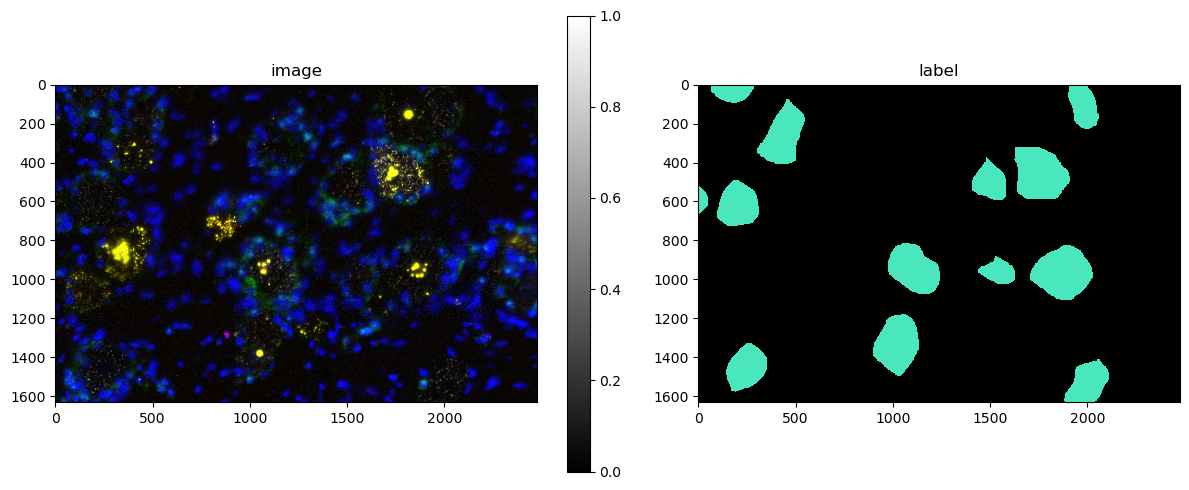

In [58]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    
    
i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)


In [59]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)


Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [60]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [61]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [62]:
#Save model to the specified directory
model = StarDist2D(conf, name='NeuronSegFL', basedir='C:/Users/ya-chen.chuang/Documents/QuPath/models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [63]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

1/1 [==============================] - 0s 41ms/step
median object size:      [1633. 2451.]
network field of view :  [94 94]


In [64]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


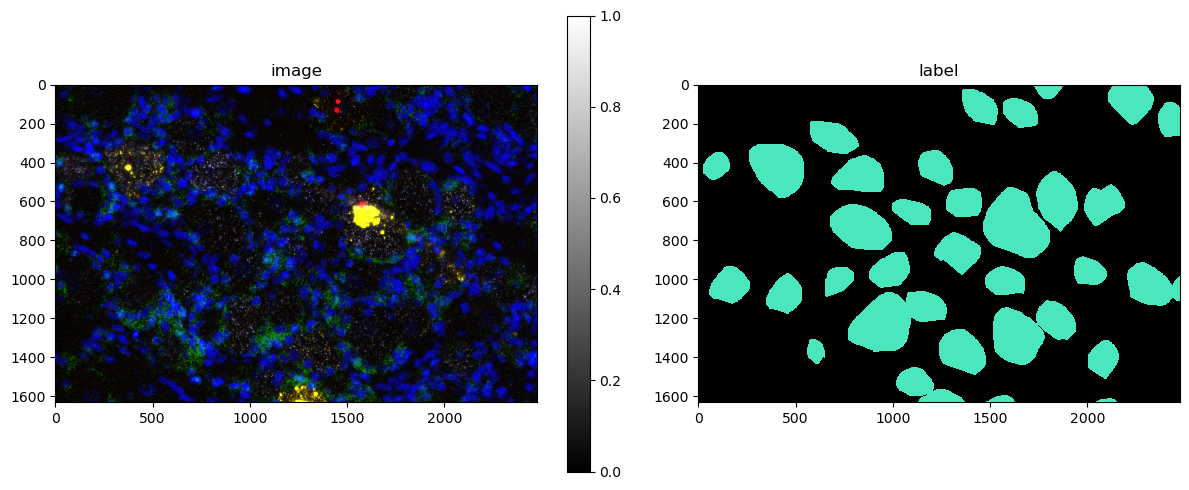

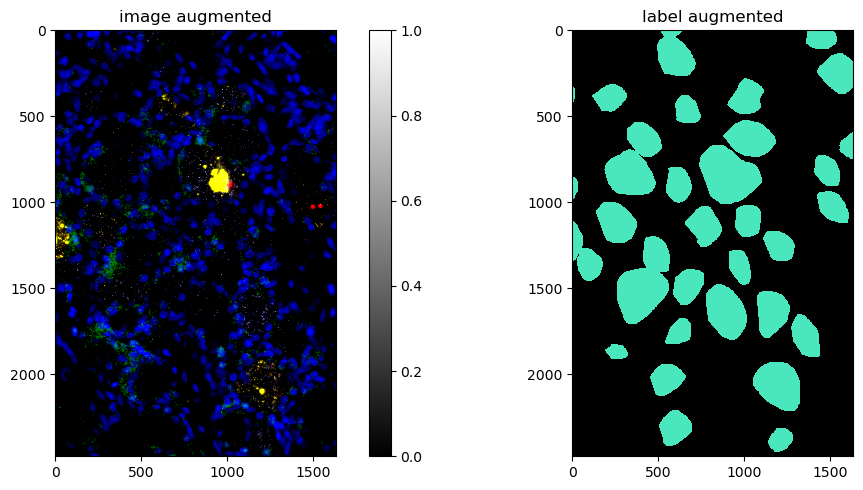

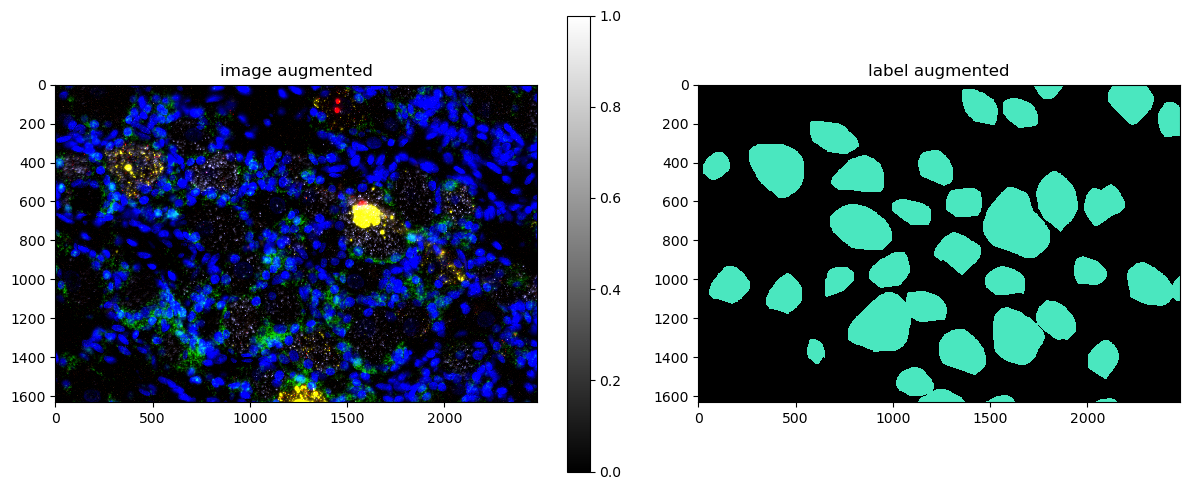

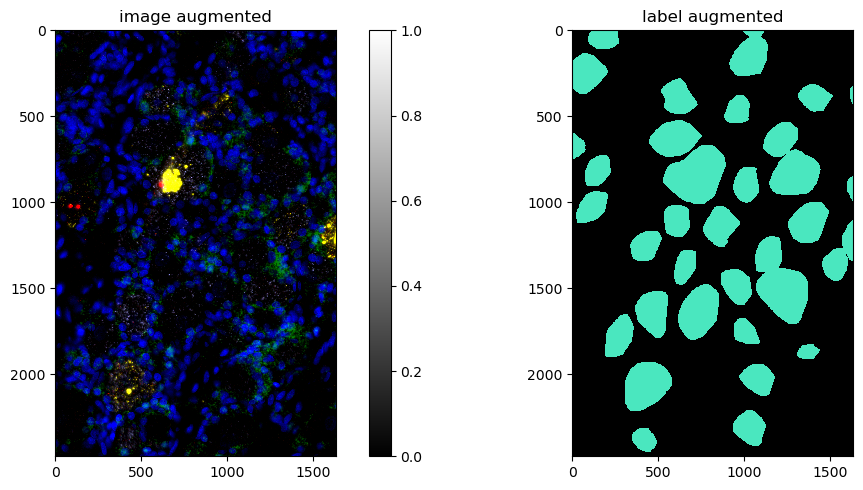

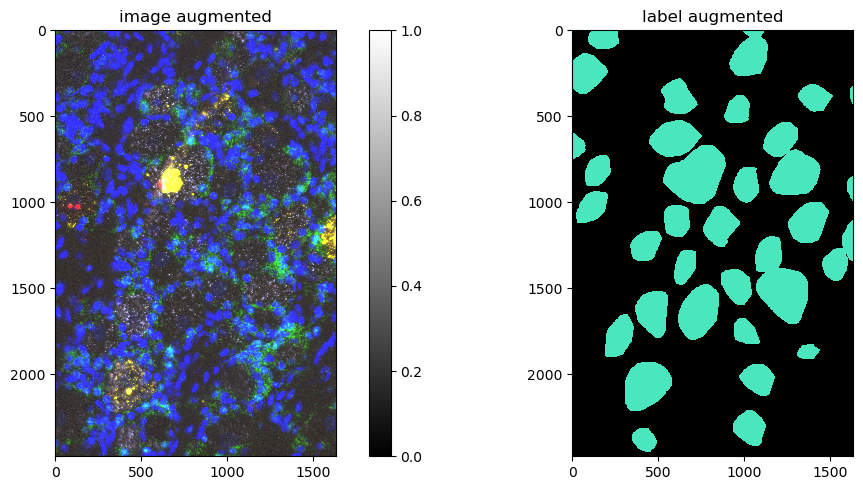

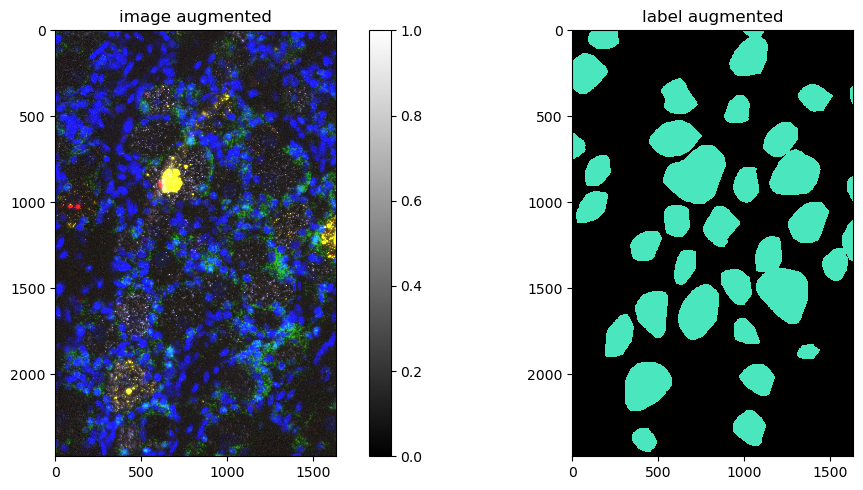

In [65]:
# plot some augmented examples
img, lbl = X[5],Y[5]
plot_img_label(img, lbl)
for _ in range(5):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [84]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=50, steps_per_epoch=100)

Epoch 1/50
100/100 [==============================] - 105s 1s/step - loss: 3.6534 - prob_loss: 0.2360 - dist_loss: 17.0869 - prob_kld: 0.1138 - dist_relevant_mae: 17.0823 - dist_relevant_mse: 686.3669 - dist_dist_iou_metric: 0.5633 - val_loss: 4.0142 - val_prob_loss: 0.1720 - val_dist_loss: 19.2110 - val_prob_kld: 0.0637 - val_dist_relevant_mae: 19.2066 - val_dist_relevant_mse: 649.7197 - val_dist_dist_iou_metric: 0.5846 - lr: 3.0000e-04
Epoch 2/50
100/100 [==============================] - 97s 965ms/step - loss: 3.7087 - prob_loss: 0.2298 - dist_loss: 17.3945 - prob_kld: 0.1085 - dist_relevant_mae: 17.3898 - dist_relevant_mse: 719.9993 - dist_dist_iou_metric: 0.5661 - val_loss: 5.0788 - val_prob_loss: 0.1963 - val_dist_loss: 24.4127 - val_prob_kld: 0.0879 - val_dist_relevant_mae: 24.4088 - val_dist_relevant_mse: 989.6906 - val_dist_dist_iou_metric: 0.5140 - lr: 3.0000e-04
Epoch 3/50
100/100 [==============================] - 101s 1s/step - loss: 3.7647 - prob_loss: 0.2338 - dist_loss:

Epoch 14/50
100/100 [==============================] - 104s 1s/step - loss: 3.5726 - prob_loss: 0.2472 - dist_loss: 16.6271 - prob_kld: 0.1158 - dist_relevant_mae: 16.6225 - dist_relevant_mse: 688.1612 - dist_dist_iou_metric: 0.5853 - val_loss: 4.3532 - val_prob_loss: 0.1958 - val_dist_loss: 20.7873 - val_prob_kld: 0.0874 - val_dist_relevant_mae: 20.7835 - val_dist_relevant_mse: 706.3191 - val_dist_dist_iou_metric: 0.5751 - lr: 3.0000e-04
Epoch 15/50
100/100 [==============================] - 100s 996ms/step - loss: 3.5312 - prob_loss: 0.2194 - dist_loss: 16.5588 - prob_kld: 0.0880 - dist_relevant_mae: 16.5543 - dist_relevant_mse: 669.4886 - dist_dist_iou_metric: 0.5868 - val_loss: 4.1265 - val_prob_loss: 0.1743 - val_dist_loss: 19.7614 - val_prob_kld: 0.0659 - val_dist_relevant_mae: 19.7575 - val_dist_relevant_mse: 642.8695 - val_dist_dist_iou_metric: 0.5893 - lr: 3.0000e-04
Epoch 16/50
100/100 [==============================] - 102s 1s/step - loss: 3.6597 - prob_loss: 0.2143 - dist_l

Epoch 27/50
100/100 [==============================] - 87s 872ms/step - loss: 3.5702 - prob_loss: 0.2160 - dist_loss: 16.7711 - prob_kld: 0.0884 - dist_relevant_mae: 16.7665 - dist_relevant_mse: 693.3528 - dist_dist_iou_metric: 0.5897 - val_loss: 4.0117 - val_prob_loss: 0.1803 - val_dist_loss: 19.1573 - val_prob_kld: 0.0719 - val_dist_relevant_mae: 19.1526 - val_dist_relevant_mse: 626.5251 - val_dist_dist_iou_metric: 0.5920 - lr: 3.0000e-04
Epoch 28/50
100/100 [==============================] - 80s 803ms/step - loss: 3.2502 - prob_loss: 0.2024 - dist_loss: 15.2388 - prob_kld: 0.0826 - dist_relevant_mae: 15.2345 - dist_relevant_mse: 567.3999 - dist_dist_iou_metric: 0.6005 - val_loss: 4.2094 - val_prob_loss: 0.2265 - val_dist_loss: 19.9147 - val_prob_kld: 0.1181 - val_dist_relevant_mae: 19.9103 - val_dist_relevant_mse: 666.6975 - val_dist_dist_iou_metric: 0.5951 - lr: 3.0000e-04
Epoch 29/50
100/100 [==============================] - 83s 834ms/step - loss: 3.4469 - prob_loss: 0.2114 - dis

Epoch 40/50
100/100 [==============================] - 95s 944ms/step - loss: 3.4212 - prob_loss: 0.2316 - dist_loss: 15.9480 - prob_kld: 0.0968 - dist_relevant_mae: 15.9434 - dist_relevant_mse: 630.9512 - dist_dist_iou_metric: 0.6063 - val_loss: 4.2354 - val_prob_loss: 0.1741 - val_dist_loss: 20.3062 - val_prob_kld: 0.0658 - val_dist_relevant_mae: 20.3017 - val_dist_relevant_mse: 684.9653 - val_dist_dist_iou_metric: 0.5870 - lr: 3.0000e-04
Epoch 41/50
100/100 [==============================] - 93s 931ms/step - loss: 3.2065 - prob_loss: 0.2118 - dist_loss: 14.9739 - prob_kld: 0.0786 - dist_relevant_mae: 14.9695 - dist_relevant_mse: 556.1986 - dist_dist_iou_metric: 0.6262 - val_loss: 4.6083 - val_prob_loss: 0.2857 - val_dist_loss: 21.6129 - val_prob_kld: 0.1773 - val_dist_relevant_mae: 21.6083 - val_dist_relevant_mse: 748.5299 - val_dist_dist_iou_metric: 0.5698 - lr: 3.0000e-04
Epoch 42/50
100/100 [==============================] - 93s 932ms/step - loss: 3.2221 - prob_loss: 0.2240 - dis

In [85]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 137ms/step


NMS threshold = 0.5:  80%|████████  | 16/20 [00:23<00:05,  1.49s/it, 0.499 -> 0.000]


Using optimized values: prob_thresh=0.500924, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5009242932284944, 'nms': 0.3}

In [86]:
#Load saved model
my_model = StarDist2D(None, name='NeuronSegFL', basedir='C:/Users/ya-chen.chuang/Documents/QuPath/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.500924, nms_thresh=0.3.


In [87]:
model=my_model

In [88]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 136ms/step


 50%|█████     | 1/2 [00:04<00:04,  4.89s/it]

1/1 [==============================] - 0s 136ms/step


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


DatasetMatching(criterion='iou', thresh=0.05, fp=87, tp=0, fn=2, precision=0, recall=0, accuracy=0, f1=0, n_true=2, n_pred=87, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

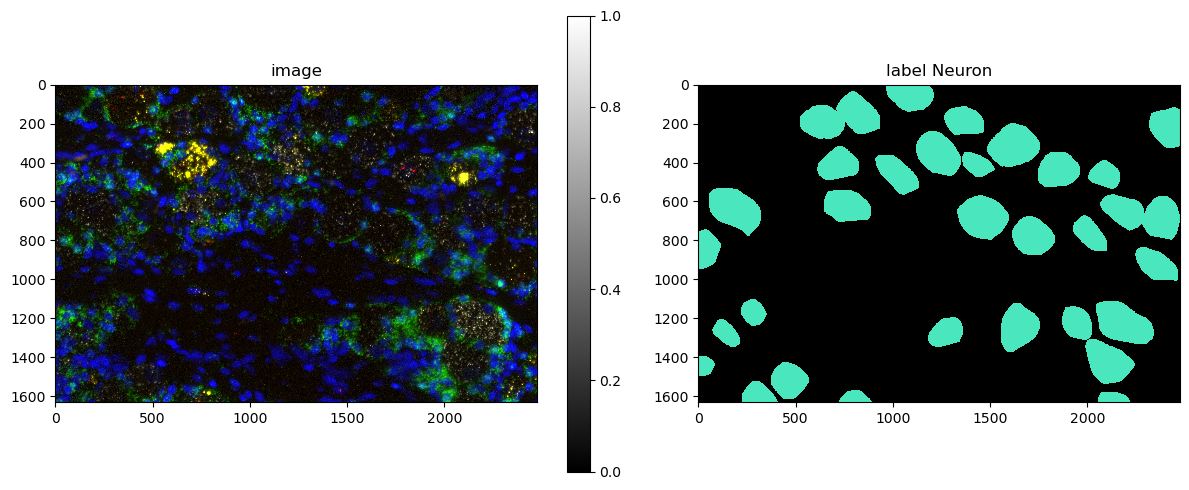

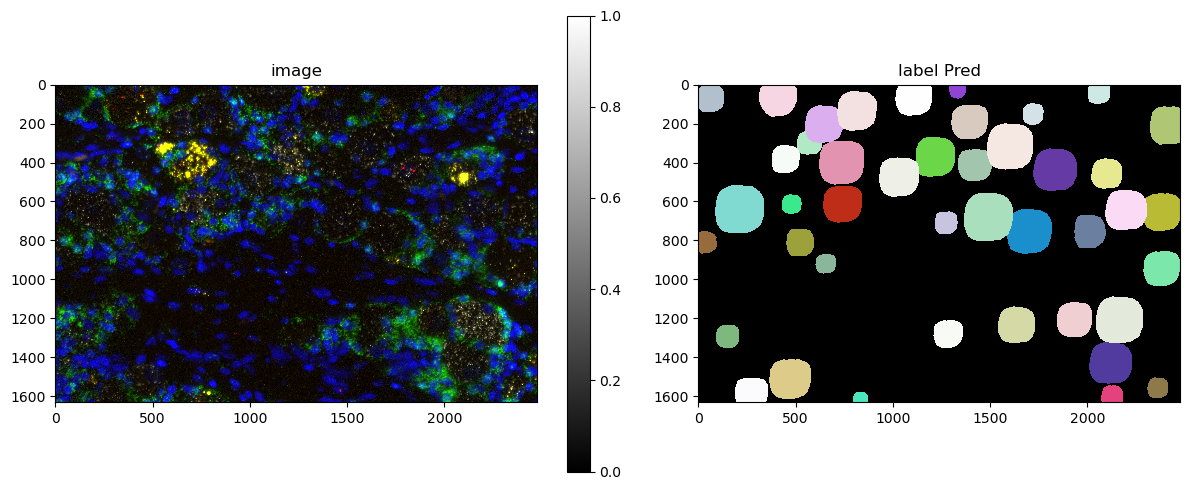

In [104]:
#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label Neuron")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


# taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0]
taus = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.05)]

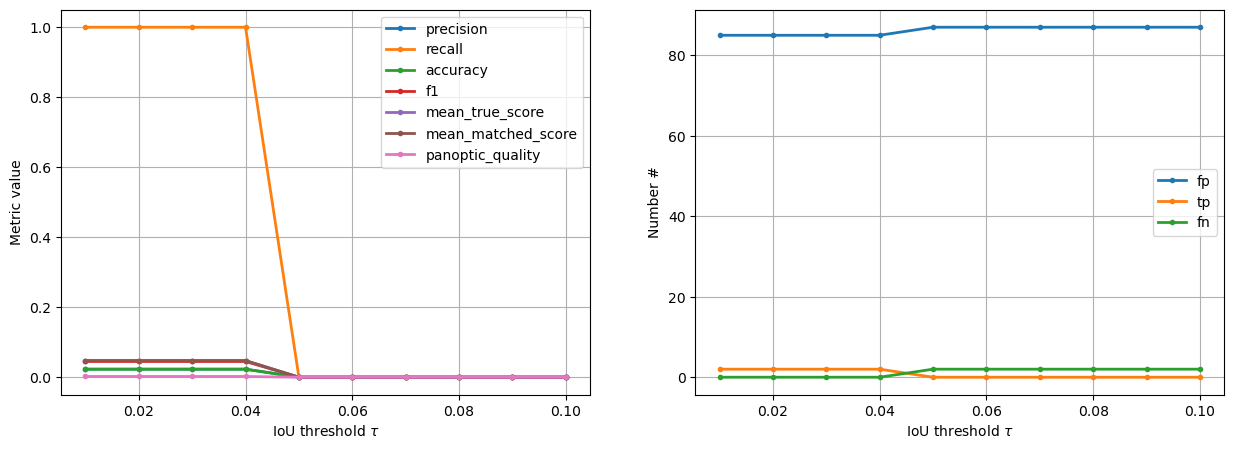

In [105]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
